In [1]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.0 MB/s eta 0:00:000:00:010:00:01:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# gpus = tf.config.experimental.list_physical_devices("GPU")
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
data_dir = "./data/finalData/handPicked/MBTI_Images/"

In [7]:
# need to mogrify all the images in the png format... command for same in each directory is "mogrify *.png"

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)            

# Loading data

In [11]:
# tf.keras.utils.image_dataset_from_directory??

In [12]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(200, 200), batch_size=32) # Creating/Building the data pipeline

Found 2948 files belonging to 16 classes.


In [13]:
data_iterator = data.as_numpy_iterator() # Allow us to access our data pypeline

In [14]:
batch = data_iterator.next() # actually accessing the data pipeline

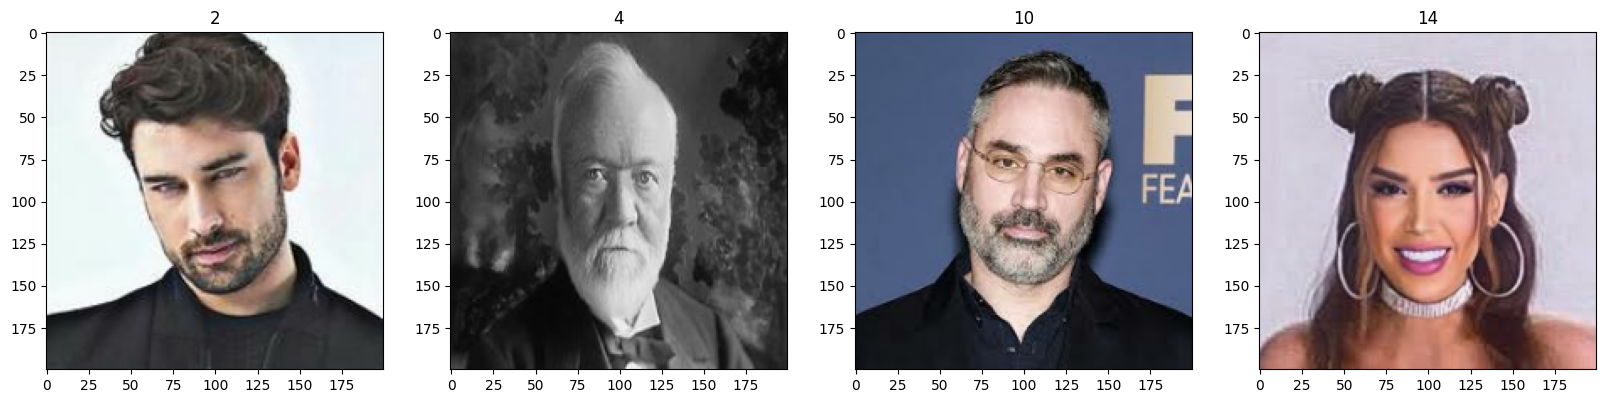

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Data Preprocessing

## Scale

In [16]:
# We are over-riding our data here, we can give it to some other variable also
data = data.map(lambda x,y: (x/255, y)) # Adding a map function to the pipeline, to transform the data set from 0 to 1, rather than from 0 to 255...

### Here we need to map our different preprocessed function, or first run the pre-processing function, and then use that data. We should try to integrate the preprocessing function (ie. just cropping the faces) to the pypeline, this might help.

In [17]:
scaled_iterator = data.as_numpy_iterator()

In [18]:
batch = scaled_iterator.next()

In [19]:
print(batch[0].min())
print(batch[0].max())

0.0
1.0


## Split Data

In [20]:
len(data)

93

In [27]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) + 1
test_size = int(len(data)*.1)
print(train_size, test_size, val_size)

65 9 19


In [28]:
train_size + val_size + test_size == len(data)

True

In [29]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Deep Model

## Model Building

In [30]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input

In [32]:
# model = Sequential()
# Here, we are using the sequential model. We will need to use the functional model in the keras library
# to make multiple input and multiple output. (Actually we only need single input and multiple output).

In [33]:
# Input layer
inputs = Input(shape=(200, 200, 3))

# First Convolutional Layer
x = Conv2D(16, (3,3), strides=1, activation='relu')(inputs)
x = MaxPooling2D()(x)

# Second Convolutional Layer
x = Conv2D(32, (3,3), strides=1, activation='relu')(x)
x = MaxPooling2D()(x)

# Third Convolutional Layer
x = Conv2D(16, (3,3), strides=1, activation='relu')(x)
x = MaxPooling2D()(x)

# Flattening the results into a vector
x = Flatten()(x)

# Fully connected layer with 256 units
x = Dense(256, activation='relu')(x)

# Output layer for 16 classes with softmax activation
outputs = Dense(16, activation='softmax')(x)

# Defining the model
model = Model(inputs=inputs, outputs=outputs)

# Compiling the model
model.compile(optimizer='adam', 
              loss=tf.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 198, 198, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8464)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,167,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,180,864 (8.32 MB)

 Trainable params: 2,180,864 (8.32 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [35]:
logdir='logs'

In [36]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [37]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.0738 - loss: 2.9316 - val_accuracy: 0.0757 - val_loss: 2.7531
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.1253 - loss: 2.7245 - val_accuracy: 0.1184 - val_loss: 2.6913
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.1999 - loss: 2.5117 - val_accuracy: 0.1842 - val_loss: 2.6667
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.4384 - loss: 1.8902 - val_accuracy: 0.2418 - val_loss: 2.7338
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.6894 - loss: 1.0730 - val_accuracy: 0.2747 - val_loss: 3.5229
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.8901 - loss: 0.4400 - val_accuracy: 0.3306 - val_loss: 4.1641
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.9480 - loss: 0.2430 - val_accuracy: 0.3487 - val_loss: 4.5518
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.9684 - loss: 0.1670 - val_accuracy: 0.31

## Plot performance

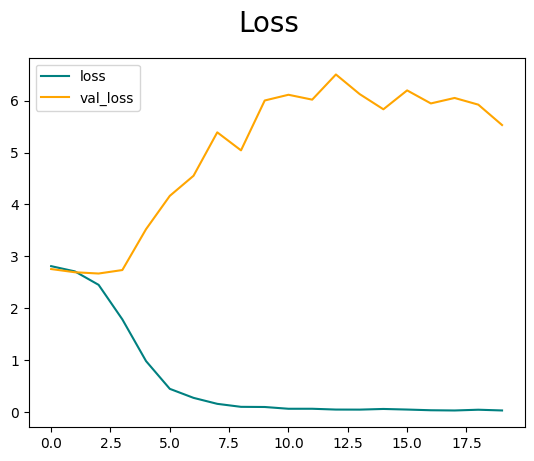

In [38]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

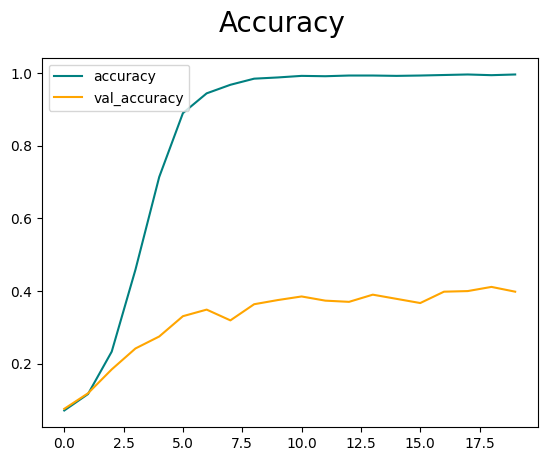

In [39]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate

In [40]:
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy

In [41]:
pre = Precision()
re = Recall()
acc = SparseCategoricalAccuracy()

In [43]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    yhat_classes = np.argmax(yhat, axis=1)
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-12-03 13:52:09.371183: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [44]:
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

Precision: 0.9882352948188782
Recall: 0.9824561476707458
Accuracy: 0.04615384712815285


# Test

In [45]:
imageName = "ESFP/A.J._Jackson2.jpeg"
img = cv2.imread(data_dir + imageName) # Read some image, and test...
# plt.imshow(img)
# plt.show()

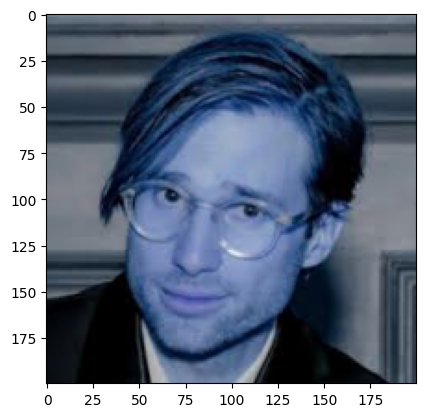

In [46]:
resize = tf.image.resize(img, (200,200))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [47]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [48]:
# print(yhat)
m = max(yhat[0])
# print(m)
categoryNum = int(np.where(yhat[0] == m)[0])

categoryMap = {
    0: "ENFJ",
    1: "ENFP",
    2: "ENTJ",
    3: "ENTP",
    4: "ESFJ",
    5: "ESFP",
    6: "ESTJ",
    7: "ESTP",
    8: "INFJ",
    9: "INFP",
    10: "INTJ",
    11: "INTP",
    12: "ISFJ",
    13: "ISFP",
    14: "ISTJ",
    15: "ISTP"
}

print(f"Personality Type is {categoryMap[categoryNum]}")

Personality Type is ESFP


# Save the model

In [49]:
from tensorflow.keras.models import load_model


In [50]:
model.save(os.path.join('models','imageclassifierModel1Version2.keras'))

In [53]:
new_model = load_model('./models/imageclassifier.keras')